In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

from datautils import *
# from sphUtils import *
from lossFunctions import *

In [2]:

from plotting import *
plt.style.use('dark_background')
from tqdm.notebook import trange, tqdm

In [3]:
from rbfNet import *
from tqdm.notebook import trange, tqdm

In [22]:
basePath = '~/dev/datasets/WBCSPH2Dc/train'
basePath = os.path.expanduser(basePath)

# simulationFiles = [basePath + '/' + f for f in os.listdir(basePath) if f.endswith('.zst')]
simulationFiles = [basePath + '/' + f for f in os.listdir(basePath) if f.endswith('.hdf5')]
# for i, c in enumerate(simulationFiles):
#     print(i ,c)
#     
# simulationFiles  = [simulationFiles[0]]
simulationFiles = simulationFiles[:10]

training = []
validation = []
testing = []

for s in tqdm(simulationFiles):
    f, s, u = splitFile(s, split = False, cutoff = -4, skip = 0)
    training.append((f, (s,u)))
# for s in simulationFiles:    
#     _, train, valid, test = splitFileZSTD(s, split = True, limitRollOut = False, skip = 0, cutoff = 1800, distance = 1)
#     training.append((s,train))
#     validation.append((s,valid))
#     testing.append((s,test))
# debugPrint(training)

  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:

class RbfNet(torch.nn.Module):
    def __init__(self, fluidFeatures, boundaryFeatures, layers = [32,64,64,2], denseLayer = True, activation = 'relu',
                coordinateMapping = 'polar', n = 8, m = 8, windowFn = None, rbf_x = 'linear', rbf_y = 'linear', batchSize = 32, ignoreCenter = False):
        super().__init__()
        self.centerIgnore = ignoreCenter
#         debugPrint(layers)
        
        self.features = copy.copy(layers)
#         debugPrint(fluidFeatures)
#         debugPrint(boundaryFeatures)
        self.convs = torch.nn.ModuleList()
        self.fcs = torch.nn.ModuleList()
        self.relu = getattr(nn.functional, 'relu')
#         debugPrint(fluidFeatures)

        self.convs.append(RbfConv(
            in_channels = fluidFeatures, out_channels = self.features[0],
            dim = 2, size = [n,m],
            rbf = [rbf_x, rbf_y],
            linearLayer = False, biasOffset = False, feedThrough = False,
            preActivation = None, postActivation = activation,
            coordinateMapping = coordinateMapping,
            batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
        
        self.convs.append(RbfConv(
            in_channels = boundaryFeatures, out_channels = self.features[0],
            dim = 2, size = [n,m],
            rbf = [rbf_x, rbf_y],
            linearLayer = False, biasOffset = False, feedThrough = False,
            preActivation = None, postActivation = activation,
            coordinateMapping = coordinateMapping,
            batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
        
        self.fcs.append(nn.Linear(in_features=fluidFeatures,out_features= layers[0],bias=False))
        torch.nn.init.xavier_uniform_(self.fcs[-1].weight)

        self.features[0] = self.features[0]
#         self.fcs.append(nn.Linear(in_features=96,out_features= 2,bias=False))
        
        for i, l in enumerate(layers[1:-1]):
#             debugPrint(layers[i])
#             debugPrint(layers[i+1])
            self.convs.append(RbfConv(
                in_channels = (3 * self.features[0]) if i == 0 else self.features[i], out_channels = layers[i+1],
                dim = 2, size = [n,m],
                rbf = [rbf_x, rbf_y],
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = coordinateMapping,
                batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
            self.fcs.append(nn.Linear(in_features=3 * layers[0] if i == 0 else layers[i],out_features=layers[i+1],bias=False))
            torch.nn.init.xavier_uniform_(self.fcs[-1].weight)
            
        self.convs.append(RbfConv(
            in_channels = self.features[-2], out_channels = self.features[-1],
                dim = 2, size = [n,m],
                rbf = [rbf_x, rbf_y],
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = coordinateMapping,
                batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
        self.fcs.append(nn.Linear(in_features=layers[-2],out_features=self.features[-1],bias=False))
        torch.nn.init.xavier_uniform_(self.fcs[-1].weight)


    def forward(self, \
                fluidPositions, boundaryPositions, \
                fluidFeatures, boundaryFeatures,\
                attributes, fluidBatches = None, boundaryBatches = None):
        fi, fj = radius(fluidPositions, fluidPositions, attributes['support'], max_num_neighbors = 256, batch_x = fluidBatches, batch_y = fluidBatches)
        bf, bb = radius(boundaryPositions, fluidPositions, attributes['support'], max_num_neighbors = 256, batch_x = boundaryBatches, batch_y = fluidBatches)
        if self.centerIgnore:
            nequals = fi != fj

        i, ni = torch.unique(fi, return_counts = True)
        b, nb = torch.unique(bf, return_counts = True)
        ni[i[b]] += nb
        self.li = torch.exp(-1 / np.float32(attributes['targetNeighbors']) * ni)
        
        boundaryEdgeIndex = torch.stack([bf, bb], dim = 0)
        boundaryEdgeLengths = (boundaryPositions[boundaryEdgeIndex[1]] - fluidPositions[boundaryEdgeIndex[0]])/attributes['support']
        boundaryEdgeLengths = boundaryEdgeLengths.clamp(-1,1)
        if self.centerIgnore:
            fluidEdgeIndex = torch.stack([fi[nequals], fj[nequals]], dim = 0)
        else:
            fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
        fluidEdgeLengths = -(fluidPositions[fluidEdgeIndex[1]] - fluidPositions[fluidEdgeIndex[0]])/attributes['support']
        fluidEdgeLengths = fluidEdgeLengths.clamp(-1,1)
#         if verbose:
#             print('prepared network with inputs:')
#             print('fluidPositions', fluidPositions[:4])
#             print('fluidFeatures', fluidFeatures[:4])
#             print('boundaryPositions', boundaryPositions[:4])
#             print('boundaryFeatures', boundaryFeatures[:4])
#             print('fluid neighbors:', fluidEdgeIndex.shape)
#             print('fluid neighbor distances', fluidEdgeLengths[:4])
#             print('boundary neighbors:', boundaryEdgeIndex.shape)
#             print('boundary neighbor distances', boundaryEdgeLengths[:4])
#             print('num neighbors', ni[:4])
#             print('li', self.li[:4])
            
            
        linearOutput = self.relu(self.fcs[0](fluidFeatures))
        boundaryConvolution = self.convs[1]((fluidFeatures, boundaryFeatures), boundaryEdgeIndex, boundaryEdgeLengths)
        fluidConvolution = self.convs[0]((fluidFeatures, fluidFeatures), fluidEdgeIndex, fluidEdgeLengths)
        ans = torch.hstack((linearOutput, fluidConvolution, boundaryConvolution))
        if verbose:
#             print('linear output', linearOutput[:4])
#             print('boundary convolution output', boundaryConvolution[:4])
#             print('fluid convolution output', fluidConvolution[:4])
            print('first layer output', ans[:4])
        
        layers = len(self.convs)
        for i in range(2,layers):
            ansConv = self.convs[i]((ans, ans), fluidEdgeIndex, fluidEdgeLengths)
            ansDense = self.fcs[i - 1](ans)
            
            
            if self.features[i-2] == self.features[i-1] and ans.shape == ansConv.shape:
                ans = ansConv #+ ansDense + ans
            else:
                ans = ansConv #+ ansDense
#             if verbose:
#                 print('\tlayer', i)
#                 print('\tlinear output', ansDense[:4])
#                 print('\tfluid convolution output', ansConv[:4])
#                 print('\tlayer output', ans[:4])
                
            if i != layers - 1:
                ans = self.relu(ans)
            if verbose:
                print('\tlayer output after activation', ans[:4])
        return ans
            

In [24]:

# class RbfNet(torch.nn.Module):
#     def __init__(self, fluidFeatures, boundaryFeatures, layers = [32,64,64,2], denseLayer = True, activation = 'relu',
#                 coordinateMapping = 'polar', n = 8, m = 8, windowFn = None, rbf_x = 'linear', rbf_y = 'linear', batchSize = 32, ignoreCenter = False):
#         super().__init__()
#         self.centerIgnore = ignoreCenter
# #         debugPrint(layers)
        
#         self.features = copy.copy(layers)
# #         debugPrint(fluidFeatures)
# #         debugPrint(boundaryFeatures)
#         self.convs = torch.nn.ModuleList()
#         self.fcs = torch.nn.ModuleList()
#         self.relu = getattr(nn.functional, 'relu')
# #         debugPrint(fluidFeatures)

#         self.convs.append(RbfConv(
#             in_channels = fluidFeatures, out_channels = self.features[0],
#             dim = 2, size = [n,m],
#             rbf = [rbf_x, rbf_y],
#             linearLayer = False, biasOffset = False, feedThrough = False,
#             preActivation = None, postActivation = activation,
#             coordinateMapping = coordinateMapping,
#             batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
        
# #         self.convs.append(RbfConv(
# #             in_channels = boundaryFeatures, out_channels = self.features[0],
# #             dim = 2, size = [n,m],
# #             rbf = [rbf_x, rbf_y],
# #             linearLayer = False, biasOffset = False, feedThrough = False,
# #             preActivation = None, postActivation = activation,
# #             coordinateMapping = coordinateMapping,
# #             batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
        
#         self.fcs.append(nn.Linear(in_features=fluidFeatures,out_features= layers[0],bias=False))
#         torch.nn.init.xavier_uniform_(self.fcs[-1].weight)

#         self.features[0] = self.features[0]
# #         self.fcs.append(nn.Linear(in_features=96,out_features= 2,bias=False))
        
#         for i, l in enumerate(layers[1:-1]):
# #             debugPrint(layers[i])
# #             debugPrint(layers[i+1])
#             self.convs.append(RbfConv(
#                 in_channels = (2 * self.features[0]) if i == 0 else self.features[i], out_channels = layers[i+1],
#                 dim = 2, size = [n,m],
#                 rbf = [rbf_x, rbf_y],
#                 linearLayer = False, biasOffset = False, feedThrough = False,
#                 preActivation = None, postActivation = None,
#                 coordinateMapping = coordinateMapping,
#                 batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
#             self.fcs.append(nn.Linear(in_features=2 * layers[0] if i == 0 else layers[i],out_features=layers[i+1],bias=False))
#             torch.nn.init.xavier_uniform_(self.fcs[-1].weight)
            
#         self.convs.append(RbfConv(
#             in_channels = self.features[-2], out_channels = self.features[-1],
#                 dim = 2, size = [n,m],
#                 rbf = [rbf_x, rbf_y],
#                 linearLayer = False, biasOffset = False, feedThrough = False,
#                 preActivation = None, postActivation = None,
#                 coordinateMapping = coordinateMapping,
#                 batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
#         self.fcs.append(nn.Linear(in_features=layers[-2],out_features=self.features[-1],bias=False))
#         torch.nn.init.xavier_uniform_(self.fcs[-1].weight)


#     def forward(self, \
#                 fluidPositions, boundaryPositions, \
#                 fluidFeatures, boundaryFeatures,\
#                 attributes, fluidBatches = None, boundaryBatches = None):
#         fi, fj = radius(fluidPositions, fluidPositions, attributes['support'], max_num_neighbors = 256, batch_x = fluidBatches, batch_y = fluidBatches)
#         bf, bb = radius(boundaryPositions, fluidPositions, attributes['support'], max_num_neighbors = 256, batch_x = boundaryBatches, batch_y = fluidBatches)
#         if self.centerIgnore:
#             nequals = fi != fj

#         i, ni = torch.unique(fi, return_counts = True)
#         b, nb = torch.unique(bf, return_counts = True)
#         ni[i[b]] += nb
#         self.li = torch.exp(-1 / np.float32(attributes['targetNeighbors']) * ni)
        
#         boundaryEdgeIndex = torch.stack([bf, bb], dim = 0)
#         boundaryEdgeLengths = (boundaryPositions[boundaryEdgeIndex[1]] - fluidPositions[boundaryEdgeIndex[0]])/attributes['support']
#         boundaryEdgeLengths = boundaryEdgeLengths.clamp(-1,1)
#         if self.centerIgnore:
#             fluidEdgeIndex = torch.stack([fi[nequals], fj[nequals]], dim = 0)
#         else:
#             fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
#         fluidEdgeLengths = -(fluidPositions[fluidEdgeIndex[1]] - fluidPositions[fluidEdgeIndex[0]])/attributes['support']
#         fluidEdgeLengths = fluidEdgeLengths.clamp(-1,1)
            
#         linearOutput = self.relu(self.fcs[0](fluidFeatures))
# #         boundaryConvolution = self.convs[1]((fluidFeatures, boundaryFeatures), boundaryEdgeIndex, boundaryEdgeLengths)
#         fluidConvolution = self.convs[0]((fluidFeatures, fluidFeatures), fluidEdgeIndex, fluidEdgeLengths)
#         ans = torch.hstack((linearOutput, fluidConvolution))
# #         ans = torch.hstack((linearOutput, fluidConvolution, boundaryConvolution))
        
#         layers = len(self.convs)
#         for i in range(1,layers):
#             ansConv = self.convs[i]((ans, ans), fluidEdgeIndex, fluidEdgeLengths)
#             ansDense = self.fcs[i](ans)
#             if self.features[i-2] == self.features[i-1] and ans.shape == ansConv.shape:
#                 ans = ansConv #+ ansDense + ans
#             else:
#                 ans = ansConv #+ ansDense
#             if i != layers - 1:
#                 ans = self.relu(ans)
#         return ans
            

In [25]:
batch_size = 4

train_ds = datasetLoader(training)
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size = batch_size).batch_sampler

# validation_ds = datasetLoader(validation)
# validation_dataloader = DataLoader(validation_ds, shuffle=True, batch_size = batch_size).batch_sampler

fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
# frameIndex = 750
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

debugPrint(fluidFeatures.shape)


n = 5
m = 5
coordinateMapping = 'preserving'
windowFunction = 'Spiky'
# windowFunction = 'None'
windowFn = getWindowFunction(windowFunction)
rbf_x = 'rbf gaussian'
rbf_y = 'fourier'
rbf_x = 'linear'
rbf_y = 'linear'
initialLR = 1e-3
maxRollOut = 10
epochs = 25
activation = 'relu'
# activation = 'none'
frameDistance = 1
arch = [32, 64, 64, 2]
# arch = [4,4,4,4,4,4,2]
# arch = [8,8,8,2]
n = 4
m = 4
# arch = [2,8,8,2]
# arch = [2,2,2,2,2,2,2,2]

model = RbfNet(fluidFeatures.shape[1], boundaryFeatures.shape[1], layers = arch, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = 64)


lr = initialLR
optimizer = Adam(model.parameters(), lr=lr)
model = model.to(device)

# torch.max(getLoss(simulationFiles[0], state['timestep'], prediction, config, state, loss = 'preShift'))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters', count_parameters(model))

# with torch.no_grad():
#     model.convs[0].weight[:] = torch.normal(mean = torch.ones(model.convs[0].weight.shape),  std = 1e-4)
#     model.convs[1].weight[:] = torch.normal(mean = torch.ones(model.convs[1].weight.shape),  std = 1e-4)

        
optimizer.zero_grad()
model.train()

hyperParameterDict = {}
hyperParameterDict['n'] = n
hyperParameterDict['m'] = m
hyperParameterDict['coordinateMapping'] = coordinateMapping
hyperParameterDict['rbf_x'] = rbf_x
hyperParameterDict['rbf_y'] = rbf_y
hyperParameterDict['windowFunction'] = 'yes' if windowFn is not None else 'no'
hyperParameterDict['initialLR'] = initialLR
hyperParameterDict['maxRollOut'] = maxRollOut
hyperParameterDict['epochs'] = epochs
hyperParameterDict['frameDistance'] = frameDistance
hyperParameterDict['parameters'] =  count_parameters(model)
hyperParameterDict['arch'] =  arch
dist = frameDistance
# debugPrint(hyperParameterDict)

networkPrefix = 'cconvlike'

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
exportString = '%s - n=[%2d,%2d] rbf=[%s,%s] map = %s window = %s d = %2d e = %2d distance = %2d - %s' % (networkPrefix, hyperParameterDict['n'], hyperParameterDict['m'], hyperParameterDict['rbf_x'], hyperParameterDict['rbf_y'], hyperParameterDict['coordinateMapping'], windowFunction, hyperParameterDict['frameDistance'], hyperParameterDict['epochs'], frameDistance, timestamp)

# exportPath = './trainingData/%s - %s.hdf5' %(self.config['export']['prefix'], timestamp)
if not os.path.exists('./trainingData/%s' % exportString):
    os.makedirs('./trainingData/%s' % exportString)
# self.outFile = h5py.File(self.exportPath,'w')

print('Network Hyperparameters:')
print('[n x m]: [%dx%d]'% (n, m))
print('[rbf_x x rbf_y]: [%sx%s]'% (rbf_x, rbf_y))
print('Mapping:', coordinateMapping)
print('window function:', windowFunction)
print('activation function:', activation)
print('initial learning rate: ', initialLR)
print('Training for %d epochs' % epochs)
print('Rollout limit (if applicable):', maxRollout)
print('Training with frame offset of', frameDistance)
print('Network architecture', arch)


fluidFeatures.shape [Size] = torch.Size([9445, 5])
Number of parameters 180000
Network Hyperparameters:
[n x m]: [4x4]
[rbf_x x rbf_y]: [linearxlinear]
Mapping: preserving
window function: Spiky
activation function: relu
initial learning rate:  0.001
Training for 25 epochs
Rollout limit (if applicable): 8
Training with frame offset of 1
Network architecture [32, 64, 64, 2]


In [26]:
verbose = False
def computeLoss(predictedPosition, predictedVelocity, groundTruth, modelOutput):
#     debugPrint(modelOutput.shape)
#     debugPrint(groundTruth.shape)
#     return torch.sqrt((modelOutput - groundTruth[:,-1:].to(device))**2)
    # return torch.abs(modelOutput - groundTruth[:,-1:].to(modelOutput.device))
    # return torch.linalg.norm(groundTruth[:,2:4] - predictedVelocity, dim = 1) 
    # debugPrint(groundTruth.shape)
    # debugPrint(predictedPosition.shape)
    # debugPrint(predictedVelocity.shape)
    posLoss = torch.sqrt(torch.linalg.norm(groundTruth[:,:2] - predictedPosition, dim = 1))
    if verbose:
        print('computing Loss with')
        print('predictedPositions', predictedPosition[:4])
        print('predictedVelocity', predictedVelocity[:4])
        print('groundTruth', groundTruth[:4])
        print('modelOutput', modelOutput[:4])
        print('resulting loss', posLoss[:4])
    return posLoss
    velLoss = torch.sqrt(torch.linalg.norm(groundTruth[:,2:4] - predictedVelocity, dim = 1))
    return posLoss + velLoss
    # return torch.sqrt(torch.linalg.norm(groundTruth[:,2:4] - modelOutput, dim = 1))


def runNetwork(initialPosition, initialVelocity, dt, frameDistance, gravity, fluidFeatures, boundaryPositions, boundaryFeatures, groundTruth, model,fluidBatches, boundaryBatches, li):
    if verbose:
        print('running network with')
        print('initialPosition', initialPosition[:4])
        print('initialVelocity', initialVelocity[:4])
        print('dt', dt)
        print('frameDistance', frameDistance)        
        print('gravity', gravity[:4])
        print('fluidFeatures', fluidFeatures[:4])
        print('boundaryPositions', boundaryPositions[:4])
        print('boundaryFeatures', boundaryFeatures[:4])
        print('fluidBatches', fluidBatches)
        print('boundaryBatches', boundaryBatches)
        print('li', li)
    d = (frameDistance) * ((frameDistance) + 1) / 2
    vel2 = initialVelocity + frameDistance * dt * gravity
    pos2 = initialPosition + frameDistance * dt * initialVelocity + d * dt**2 * gravity
    
    fluidFeatures = torch.hstack((fluidFeatures[:,0][:,None], vel2, fluidFeatures[:,3:]))
    if verbose:
        print('calling network with' )
        print('d', d)
        print('vel2', vel2[:4])
        print('pos2', pos2[:4])
        print('fluidFeatures', fluidFeatures[:4])
    predictions = model(pos2, boundaryPositions, fluidFeatures, boundaryFeatures, attributes, fluidBatches, boundaryBatches)

    predictedVelocity = (pos2 + predictions - initialPosition) / (frameDistance * attributes['dt'])
    predictedPositions = pos2 + predictions[:,:2]
    if verbose:
        print('predictions', predictions[:4])
        print('predictedVelocity', predictedVelocity[:4])
        print('predictedPositions', predictedPositions[:4])
    if li:
        loss = model.li * computeLoss(predictedPositions, predictedVelocity, groundTruth.to(device), predictions)
    else:
        loss = computeLoss(predictedPositions, predictedVelocity, groundTruth.to(device), predictions)

    return loss, predictedPositions, predictedVelocity
    

In [27]:
# list(cache.keys())

In [28]:
# cache.pop( cache.keys()[0])   

In [29]:
def loadData(dataset, index, featureFun, unroll = 1, frameDistance = 1):
    with record_function("load data - hdf5"): 
        fileName, frameIndex, maxRollouts = dataset[index]

        attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(unroll), frameDistance = frameDistance)
        fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = featureFun(attributes, inputData)

        return attributes, fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, inputData['fluidGravity'], groundTruthData


In [30]:
def loadBatch(train_ds, bdata, featureFun, unroll = 1, frameDistance = 1):
    with record_function("load batch - hdf5"): 
        fluidPositions = []
        boundaryPositions = []
        fluidFeatures = []
        boundaryFeatures = []
        fluidBatchIndices = []
        boundaryBatchIndices = []
        groundTruths = []
        fluidGravities = []
        for i in range(unroll):
            groundTruths.append([])

        for i,b in enumerate(bdata):
            with record_function("load batch - hdf5[batch]"): 
        #         debugPrint(i)
        #         debugPrint(b)
                attributes, fluidPosition, boundaryPosition, fluidFeature, boundaryFeature, fluidGravity, groundTruth = loadData(train_ds, b, featureFun, unroll = unroll, frameDistance = frameDistance)     
        #         debugPrint(groundTruth)
                fluidPositions.append(fluidPosition)
        #         debugPrint(fluidPositions)
                boundaryPositions.append(boundaryPosition)
                fluidFeatures.append(fluidFeature)
                boundaryFeatures.append(boundaryFeature)
                
                fluidGravities.append(fluidGravity)

                batchIndex = torch.ones(fluidPosition.shape[0]) * i
                fluidBatchIndices.append(batchIndex)

                batchIndex = torch.ones(boundaryPosition.shape[0]) * i
                boundaryBatchIndices.append(batchIndex)
                for u in range(unroll):
                    groundTruths[u].append(groundTruth[u])

        fluidPositions = torch.vstack(fluidPositions)
        boundaryPositions = torch.vstack(boundaryPositions)
        fluidFeatures = torch.vstack(fluidFeatures)
        boundaryFeatures = torch.vstack(boundaryFeatures)
        fluidGravities = torch.vstack(fluidGravities)
        fluidBatchIndices = torch.hstack(fluidBatchIndices)
        boundaryBatchIndices = torch.hstack(boundaryBatchIndices)
        for u in range(unroll):
            groundTruths[u] = torch.vstack(groundTruths[u])

        return fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidGravities, fluidBatchIndices, boundaryBatchIndices, groundTruths


In [31]:
# print(simulationFiles)

In [32]:
from tqdm.notebook import tqdm
def processBatch(model, device, li, attributes, e, unroll, train_ds, bdata, frameDistance):
    with record_function("process batch"): 
        fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidGravity, fluidBatches, boundaryBatches, groundTruths = \
            loadBatch(train_ds, bdata, constructFluidFeatures, unroll, frameDistance)    


        predictedPositions = fluidPositions.to(device)
        predictedVelocity = fluidFeatures[:,1:3].to(device)

        bLosses = []
        boundaryPositions = boundaryPositions.to(device)
        fluidFeatures = fluidFeatures.to(device)
        boundaryFeatures = boundaryFeatures.to(device)
        fluidBatches = fluidBatches.to(device)
        boundaryBatches = boundaryBatches.to(device)

        gravity = torch.zeros_like(predictedVelocity)
        gravity = fluidGravity[:,:2].to(device)
        
    #     gravity[:,1] = -9.81

        for u in range(unroll):
            with record_function("prcess batch[unroll]"): 
    #         loss, predictedPositions, predictedVelocity = runNetwork(fluidPositions.to(device), inputData['fluidVelocity'].to(device), attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[0], model, None, None, True)
                loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions, boundaryFeatures, groundTruths[u], model, fluidBatches, boundaryBatches, li)

                batchedLoss = []
                for i in range(len(bdata)):
                    L = loss[fluidBatches == i]
                    Lterms = (torch.mean(L), torch.max(torch.abs(L)), torch.min(torch.abs(L)), torch.std(L))            
                    batchedLoss.append(torch.hstack(Lterms))
                batchedLoss = torch.vstack(batchedLoss).unsqueeze(0)
                bLosses.append(batchedLoss)

        bLosses = torch.vstack(bLosses)
        maxLosses = torch.max(bLosses[:,:,1], dim = 0)[0]
        minLosses = torch.min(bLosses[:,:,2], dim = 0)[0]
        meanLosses = torch.mean(bLosses[:,:,0], dim = 0)
        stdLosses = torch.mean(bLosses[:,:,3], dim = 0)


        del predictedPositions, predictedVelocity, boundaryPositions, fluidFeatures, boundaryFeatures, fluidBatches, boundaryBatches

        bLosses = bLosses.transpose(0,1)

        return bLosses, meanLosses, minLosses, maxLosses, stdLosses


def processDataLoader(e, rollout, ds, dataLoader, model, optimizer, train = True, prefix = ''):
    with record_function("prcess data loader"): 
#     pbl = gtqdms[args.gpu + args.gpus]
        losses = []
        batchIndices = []

        if train:
            model.train(True)
        else:
            model.train(False)

    #     with portalocker.Lock('README.md', flags = 0x2, timeout = None):
        t.reset(total=len(dataLoader))
        i = 0
        for bdata in dataLoader:
            with record_function("prcess data loader[batch]"): 
                if train:
                    optimizer.zero_grad()
                batchLosses, meanLosses, minLosses, maxLosses, stdLosses = processBatch(model, device, True, attributes, e, rollout, ds, bdata, frameDistance)
                batchIndices.append(np.array(bdata))
                losses.append(batchLosses.detach().cpu().numpy())

                with record_function("prcess data loader[batch] - backward"): 
                    sumLosses = torch.mean(batchLosses[:,:,0]) #+ torch.mean(batchLosses[:,:,1])
                    if train:
                        sumLosses.backward()
                        optimizer.step()
                lossString = np.array2string(torch.mean(batchLosses[:,:,0],dim=0).detach().cpu().numpy(), formatter={'float_kind':lambda x: "%.4e" % x})
                batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%04d' % x}))

        #         with portalocker.Lock('README.md', flags = 0x2, timeout = None):
                t.set_description('%24s[gpu %d]: %3d [%1d] @ %1.5e: :  %s -> %.4e' %(prefix, 0, e, rollout, lr, lossString, sumLosses.detach().cpu().numpy()))
                t.update()
                if prefix == 'training':
                    te.set_description('[gpu %d] Learning: %1.4e Validation: %1.4e' %(0, np.mean(np.mean(np.vstack(losses)[:,:,0], axis = 1)), 0))
                if prefix == 'validation':
                    te.set_description('[gpu %d] Learning: %1.4e Validation: %1.4e' %(0, trainLoss, np.mean(np.mean(np.vstack(losses)[:,:,0], axis = 1))))
                te.update()
#                 i = i + 1
#                 if i > 100:
#                     break
        bIndices  = np.hstack(batchIndices)
        losses = np.vstack(losses)

        idx = np.argsort(bIndices)
        bIndices = bIndices[idx]
        losses = losses[idx]

        epochLoss = losses
        return epochLoss


gravity.shape [Size] = torch.Size([9445, 2])
torch.mean(loss) [Tensor] = 0.01944466307759285


<IPython.core.display.Javascript object>


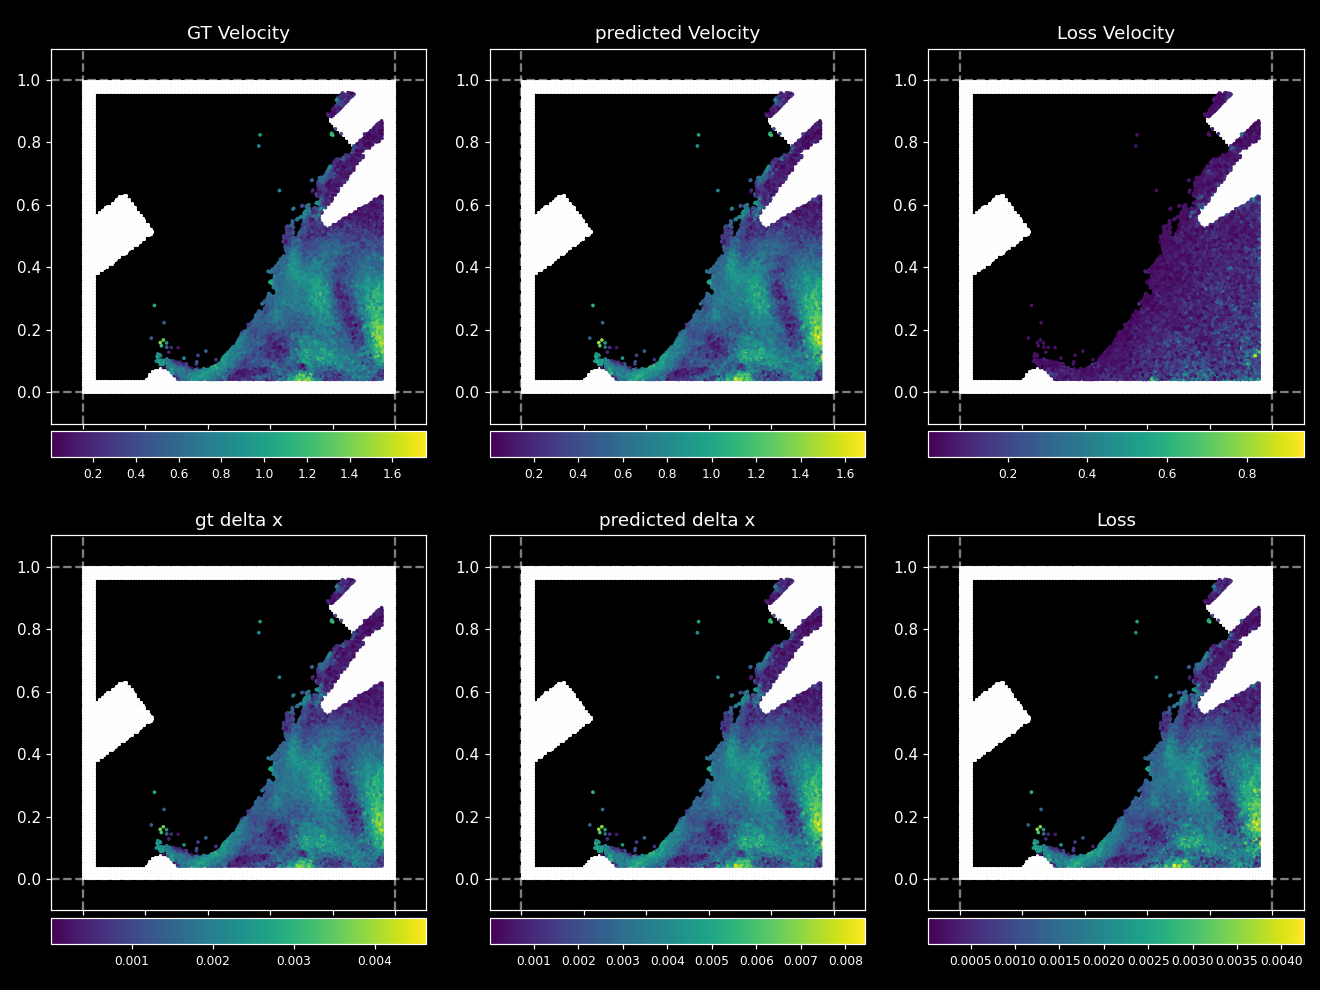

In [33]:
# fileName, frameIndex, maxRollout = train_ds[0]
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
# fileName, frameIndex, maxRollout = train_ds[len(train_ds) - 1]
# frameIndex = 750
attributes, inputData, groundTruths = loadFrame(fileName, frameIndex, 1 + np.arange(4), dist)
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

fluidFeatures = fluidFeatures.to(device)

predictedPositions = fluidPositions.to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)

gravity = inputData['fluidGravity'][:,:2].to(device) #torch.zeros_like(predictedVelocity)
debugPrint(gravity.shape)
# gravity[:,1] = -9.81

loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[0], model, None, None, True)
loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[1], model, None, None, True)

debugPrint(torch.mean(loss))
fig, axis = plt.subplots(2, 3, figsize=(12,9), sharex = False, sharey = False, squeeze = False)

def plot(fig, axis, positions, data, title = 'untitled'):
    axis.set_title(title)
    x = positions[:,0].detach().cpu().numpy()
    y = positions[:,1].detach().cpu().numpy()
    if len(data.shape) > 1:
        v = torch.linalg.norm(data, dim =1).detach().cpu().numpy()
    else:
        v = data.detach().cpu().numpy()
    # debugPrint(v)
    predSC = axis.scatter(x,y,c = v,s=2)
    axis.axis('equal')
    axis.set_xlim(-0.1,1.1)
    axis.set_ylim(-0.1,1.1)
    axis.axvline(0., alpha = 0.5, ls = '--')
    axis.axvline(1, alpha = 0.5, ls = '--')
    axis.axhline(0, alpha = 0.5, ls = '--')
    axis.axhline(1, alpha = 0.5, ls = '--')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")

    predCbar = fig.colorbar(predSC, cax=cax1,orientation='horizontal')
    predCbar.ax.tick_params(labelsize=8) 
    
    return predSC, predCbar
    
axis[0,0].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')   
axis[0,1].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')   
axis[0,2].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')   
axis[1,0].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')   
axis[1,1].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')   
axis[1,2].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')    

plot(fig, axis[0,0], positions = fluidPositions, data = groundTruths[0][:,2:4], title = 'GT Velocity')
plot(fig, axis[0,1], positions = fluidPositions, data = predictedVelocity, title = 'predicted Velocity')
plot(fig, axis[0,2], positions = fluidPositions, data = torch.linalg.norm(predictedVelocity - groundTruths[0][:,2:4].to(device), dim = 1), title = 'Loss Velocity')

plot(fig, axis[1,0], positions = fluidPositions, data = groundTruths[0][:,:2] - fluidPositions, title = 'gt delta x')
plot(fig, axis[1,1], positions = fluidPositions, data = predictedPositions - fluidPositions.to(device), title = 'predicted delta x')
plot(fig, axis[1,2], positions = fluidPositions, data = torch.linalg.norm(predictedPositions - groundTruths[0][:,:2].to(device), dim = 1), title = 'Loss')
    
fig.tight_layout()

<IPython.core.display.Javascript object>


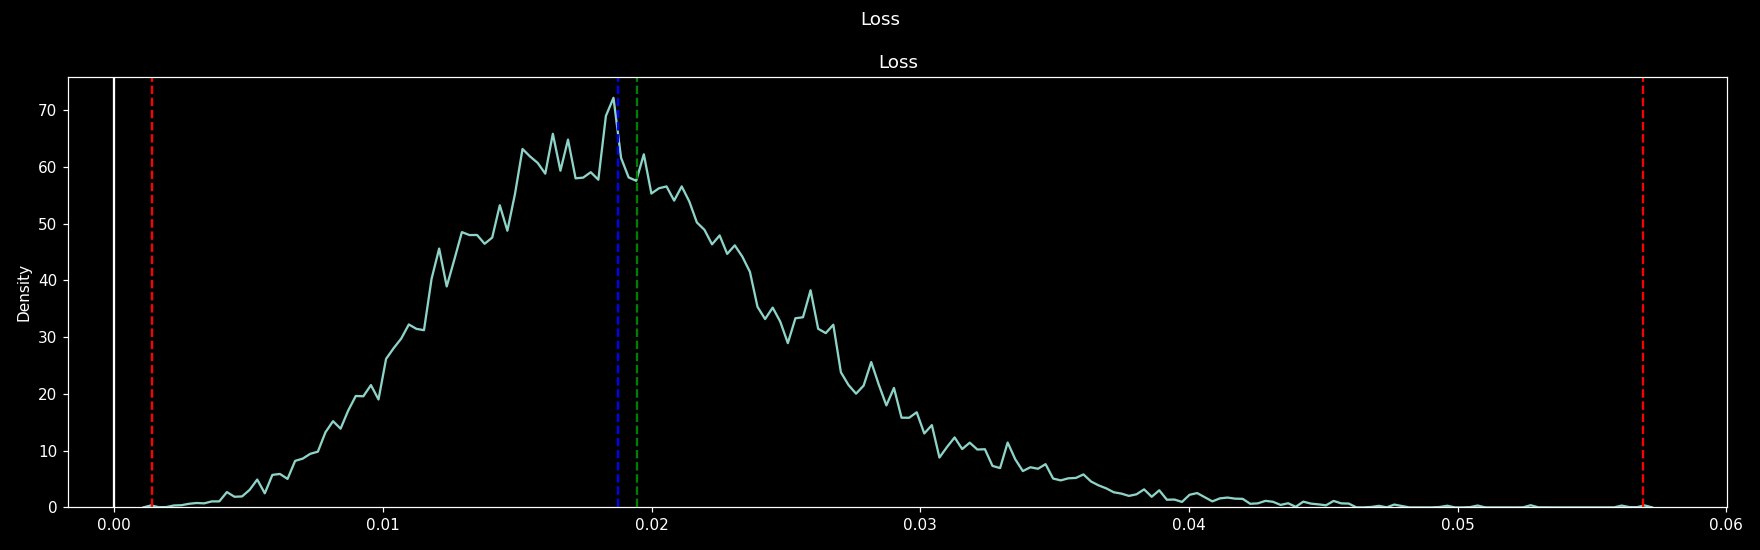

In [34]:
# trainingEpochLosses = trainingLosses[subfolders[0]]
fig, axis = plt.subplots(1, 1, figsize=(16,5), sharex = True, sharey = False, squeeze = False)

# for y in yvars:
fig.suptitle('Loss')

plt.sca(axis[0,0])
for i in range(1):
    for j in range(1):        
        axis[i,j].cla()
#             plt.sca(axis[i,j])
    axis[i,0].set_title('Loss')
#     axis[i,1].set_title('Max Loss')
#     axis[i,2].set_title('Std dev Loss')

cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

c = 0
r = 0
plt.sca(axis[r,0])
sns.kdeplot(loss.detach().cpu().numpy(), bw_adjust=.1, log_scale=False, c = cols[c % len(cols)])
axis[0,0].axvline(0)
axis[0,0].axvline(torch.min(loss).detach().cpu().numpy(), color = 'red', ls = '--')
axis[0,0].axvline(torch.median(loss).detach().cpu().numpy(), color = 'blue', ls = '--')
axis[0,0].axvline(torch.mean(loss).detach().cpu().numpy(), color = 'green', ls = '--')
axis[0,0].axvline(torch.max(loss).detach().cpu().numpy(), color = 'red', ls = '--')

fig.tight_layout()

# sns.kdeplot(losses[s][epoch,:,3], bw_adjust=.2, log_scale=True, label = '[%s = %s x %s = %s]' % (which_x, dataDict[s]['hyperParameters'][which_x], which_y, dataDict[s]['hyperParameters'][which_y]), c = cols[c % len(cols)])
# axis[r,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [35]:
# epochs = 10
# te = tqdm(range(epochs * len(train_dataloader)))
# t = tqdm(train_dataloader)

# unroll = 2
# trainingEpochLosses = []

# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
#     for i in range(1):
#         t.reset(total=len(train_dataloader))
#         losses = []
#         trainingEpochLoss = processDataLoader(epoch,unroll, train_ds, train_dataloader, model, optimizer, True, prefix = 'training')
        

# # print(prof.key_averages().table(sort_by='self_cpu_time_total'))
# print(prof.key_averages().table(sort_by='cpu_time_total'))

# prof.export_chrome_trace("traceGPU.json")

In [36]:
print(inputData['fluidVelocity'].dtype)
print(fluidFeatures.dtype)
print(groundTruthData[0].dtype)

torch.float32
torch.float32
torch.float32


In [37]:
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
# frameIndex = 750
attributes, inputData, groundTruths = loadFrame(fileName, 1854, 1 + np.arange(1), dist)
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

fluidFeatures = fluidFeatures.to(device)

predictedPositions = fluidPositions.to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)

gravity = torch.zeros_like(predictedVelocity)
gravity = inputData['fluidGravity'][:,:2].to(device)

loss, predictedPositions, predictedVelocity = runNetwork(fluidPositions.to(device), inputData['fluidVelocity'].to(device), attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[0], model, None, None, True)

debugPrint(torch.mean(loss))

torch.mean(loss) [Tensor] = 0.007424490060657263


In [38]:
verbose = False
# params = getRbfNetworkParams(fileName, frameIndex)
attributes, inputData, groundTruthData = loadFrame(fileName, 1854, 1 + np.arange(8), dist)
inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)


predictedPositions = inputData['fluidPosition'].to(device)
predictedVelocity = torch.clone(inputData['fluidVelocity']).to(device)

# print(predictedPositions[:4])

loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], 1, inputData['fluidGravity'].to(device), fluidFeatures.to(device), boundaryPositions.to(device), boundaryFeatures.to(device), groundTruthData[0].to(device), model, None, None, True)
print(torch.mean(loss))
loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], 1, inputData['fluidGravity'].to(device), fluidFeatures.to(device), boundaryPositions.to(device), boundaryFeatures.to(device), groundTruthData[1].to(device), model, None, None, True)
print(torch.mean(loss))
loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], 1, inputData['fluidGravity'].to(device), fluidFeatures.to(device), boundaryPositions.to(device), boundaryFeatures.to(device), groundTruthData[2].to(device), model, None, None, True)
print(torch.mean(loss))
loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], 1, inputData['fluidGravity'].to(device), fluidFeatures.to(device), boundaryPositions.to(device), boundaryFeatures.to(device), groundTruthData[3].to(device), model, None, None, True)
print(torch.mean(loss))
loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], 1, inputData['fluidGravity'].to(device), fluidFeatures.to(device), boundaryPositions.to(device), boundaryFeatures.to(device), groundTruthData[4].to(device), model, None, None, True)
print(torch.mean(loss))
loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], 1, inputData['fluidGravity'].to(device), fluidFeatures.to(device), boundaryPositions.to(device), boundaryFeatures.to(device), groundTruthData[5].to(device), model, None, None, True)
print(torch.mean(loss))

tensor(0.0074, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0133, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0182, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0260, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0294, device='cuda:0', grad_fn=<MeanBackward0>)


In [39]:
verbose = False
# params = getRbfNetworkParams(fileName, frameIndex)
attributes, inputData, groundTruthData = loadFrame(fileName, 1854, 1 + np.arange(8), dist)
inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)


predictedPositions = inputData['fluidPosition'].to(device)
predictedVelocity = torch.clone(inputData['fluidVelocity']).to(device)

# print(predictedPositions[:4])

loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], 1, inputData['fluidGravity'].to(device), fluidFeatures.to(device), boundaryPositions.to(device), boundaryFeatures.to(device), groundTruthData[0].to(device), model, None, None, True)
print(torch.mean(loss))
loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], 1, inputData['fluidGravity'].to(device), fluidFeatures.to(device), boundaryPositions.to(device), boundaryFeatures.to(device), groundTruthData[1].to(device), model, None, None, True)
print(torch.mean(loss))
loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], 1, inputData['fluidGravity'].to(device), fluidFeatures.to(device), boundaryPositions.to(device), boundaryFeatures.to(device), groundTruthData[2].to(device), model, None, None, True)
print(torch.mean(loss))
loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], 1, inputData['fluidGravity'].to(device), fluidFeatures.to(device), boundaryPositions.to(device), boundaryFeatures.to(device), groundTruthData[3].to(device), model, None, None, True)
print(torch.mean(loss))
loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], 1, inputData['fluidGravity'].to(device), fluidFeatures.to(device), boundaryPositions.to(device), boundaryFeatures.to(device), groundTruthData[4].to(device), model, None, None, True)
print(torch.mean(loss))
loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], 1, inputData['fluidGravity'].to(device), fluidFeatures.to(device), boundaryPositions.to(device), boundaryFeatures.to(device), groundTruthData[5].to(device), model, None, None, True)
print(torch.mean(loss))

tensor(0.0074, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0133, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0182, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0260, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0294, device='cuda:0', grad_fn=<MeanBackward0>)


In [40]:
epochs = 5
te = tqdm(range(epochs * len(train_dataloader)))
t = tqdm(train_dataloader)

unroll = 2
trainingEpochLosses = []
for epoch in range(epochs):
    t.reset(total=len(train_dataloader))
    losses = []
    trainingEpochLoss = processDataLoader(epoch,unroll, train_ds, train_dataloader, model, optimizer, True, prefix = 'training')
    trainingEpochLosses.append(trainingEpochLoss)
    torch.save(model.state_dict(), './trainingData/%s/model_%03d.torch' % (exportString, epoch))
    if epoch % 10 == 0:
        lr = lr * 0.995
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.995 * param_group['lr']

  0%|          | 0/38475 [00:00<?, ?it/s]

  0%|          | 0/7695 [00:00<?, ?it/s]

In [41]:

trainDict = {}
for i in range(len(train_ds)):
    fileName, index, _ = train_ds[i]
    trainDict['%05d' % i] = {'file':fileName, 't':int( index)}
dataSetDict = {'training' : trainDict}


dataDict = {}
for e in range(len(trainingEpochLosses)):
    dataDict['%03d' % (e+1)] = {"training": trainingEpochLosses[e]}
modelData = {'hyperParameters' : hyperParameterDict, 'dataSet': dataSetDict, 'epochData': dataDict, 'files': simulationFiles}

# if args.verbose:
#     print('Writing out result data to ./trainingData/%s/results.json' % exportString)
encodedNumpyData = json.dumps(modelData, cls=NumpyArrayEncoder, indent=4) 
with open('./trainingData/%s/results.json' % exportString, "w") as write_file:
    json.dump(modelData, write_file, cls=NumpyArrayEncoder, indent=4) 


torch.mean(loss) [Tensor] = 0.006665525483784717


<IPython.core.display.Javascript object>


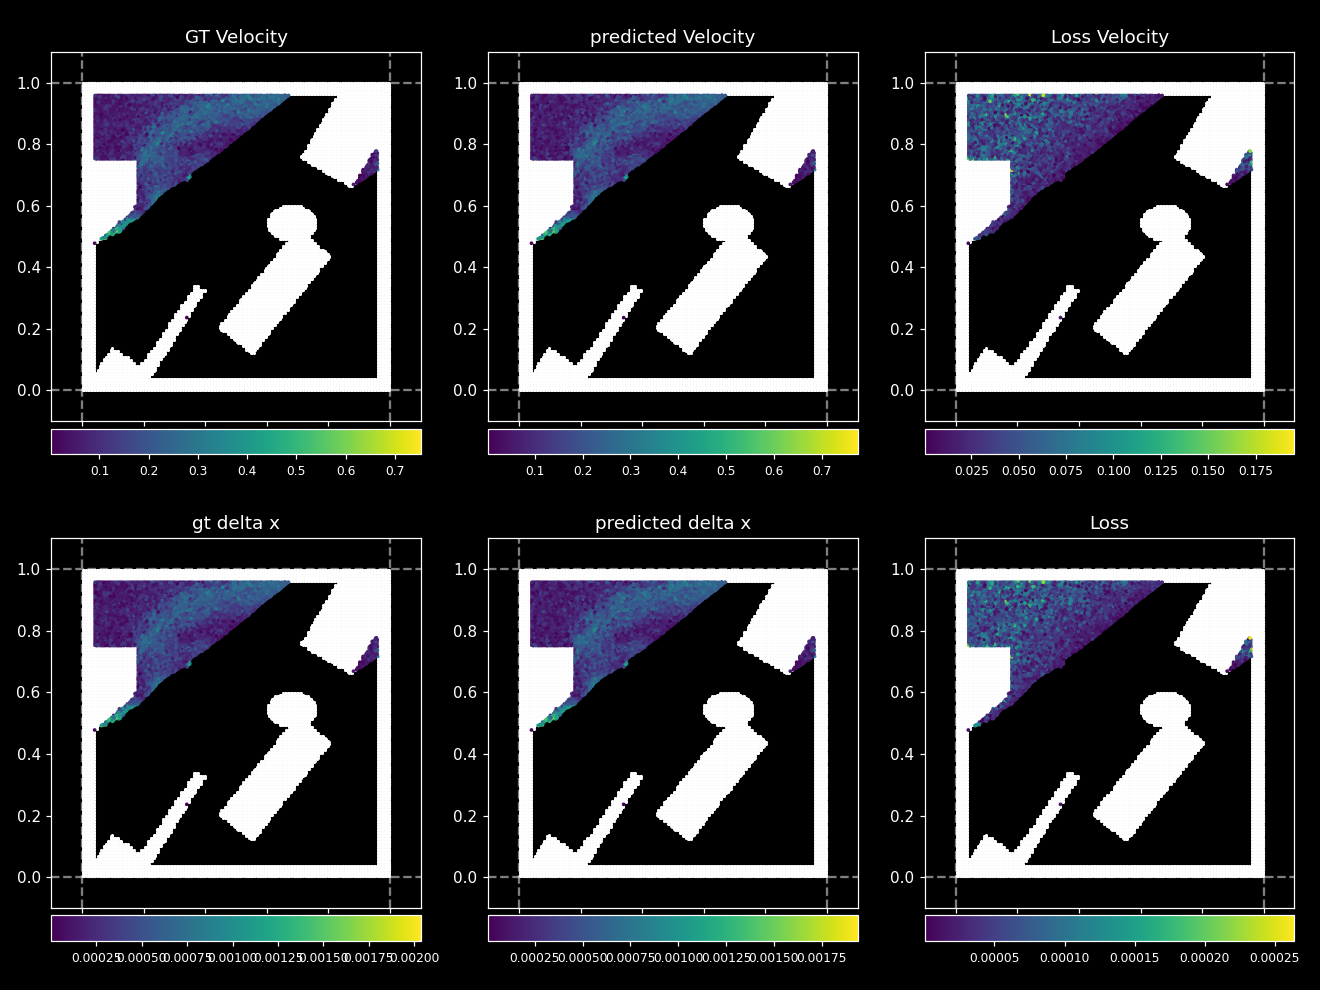

In [62]:
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
# frameIndex = 750
attributes, inputData, groundTruths = loadFrame(fileName, frameIndex, 1 + np.arange(1), dist)
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

fluidFeatures = fluidFeatures.to(device)

predictedPositions = fluidPositions.to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)

gravity = torch.zeros_like(predictedVelocity)
gravity = inputData['fluidGravity'][:,:2].to(device)
# gravity[:,1] = -9.81

loss, predictedPositions, predictedVelocity = runNetwork(fluidPositions.to(device), inputData['fluidVelocity'].to(device), attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[0], model, None, None, True)

debugPrint(torch.mean(loss))
fig, axis = plt.subplots(2, 3, figsize=(12,9), sharex = False, sharey = False, squeeze = False)

axis[0,0].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')   
axis[0,1].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')   
axis[0,2].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')   
axis[1,0].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')   
axis[1,1].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')   
axis[1,2].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')    
    
plot(fig, axis[0,0], positions = fluidPositions, data = groundTruths[0][:,2:4], title = 'GT Velocity')
plot(fig, axis[0,1], positions = fluidPositions, data = predictedVelocity, title = 'predicted Velocity')
plot(fig, axis[0,2], positions = fluidPositions, data = torch.linalg.norm(predictedVelocity - groundTruths[0][:,2:4].to(device), dim = 1), title = 'Loss Velocity')

plot(fig, axis[1,0], positions = fluidPositions, data = groundTruths[0][:,:2] - fluidPositions, title = 'gt delta x')
plot(fig, axis[1,1], positions = fluidPositions, data = predictedPositions - fluidPositions.to(device), title = 'predicted delta x')
plot(fig, axis[1,2], positions = fluidPositions, data = torch.linalg.norm(predictedPositions - groundTruths[0][:,:2].to(device), dim = 1), title = 'Loss')
    
fig.tight_layout()

<IPython.core.display.Javascript object>


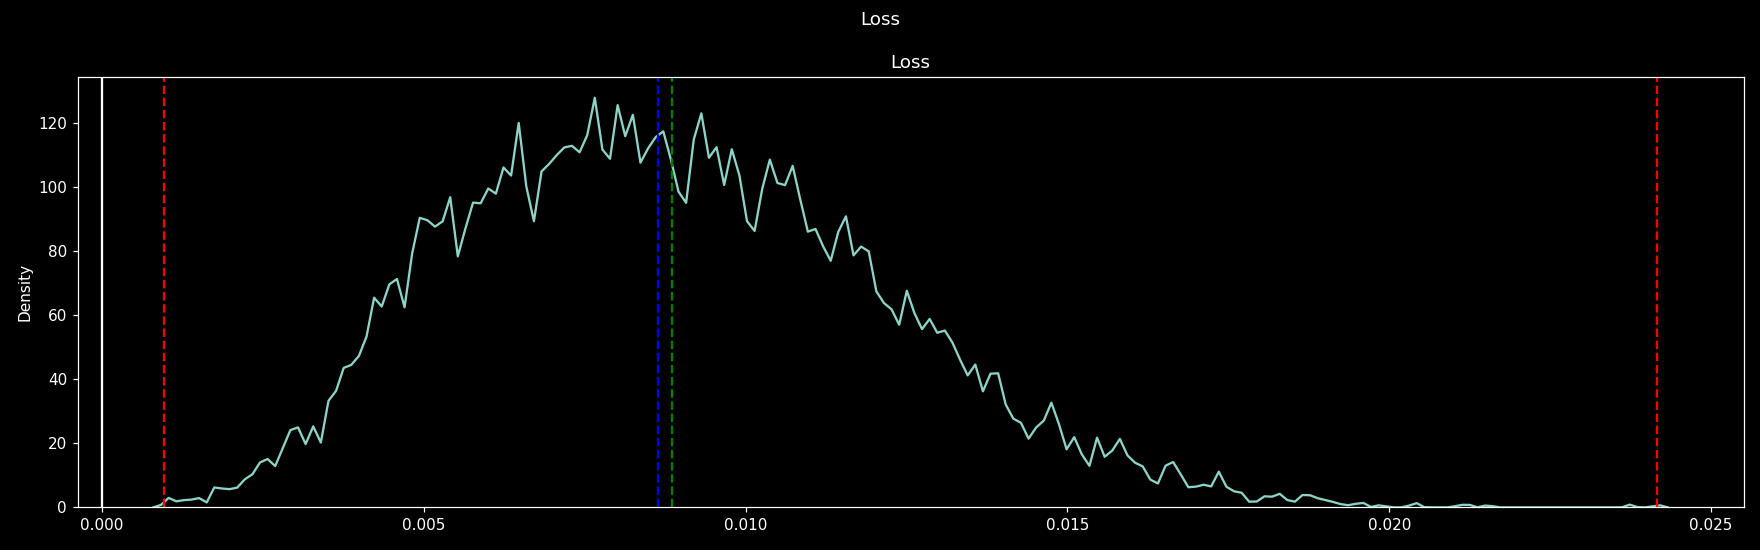

In [36]:
# trainingEpochLosses = trainingLosses[subfolders[0]]
fig, axis = plt.subplots(1, 1, figsize=(16,5), sharex = True, sharey = False, squeeze = False)

# for y in yvars:
fig.suptitle('Loss')

plt.sca(axis[0,0])
for i in range(1):
    for j in range(1):        
        axis[i,j].cla()
#             plt.sca(axis[i,j])
    axis[i,0].set_title('Loss')
#     axis[i,1].set_title('Max Loss')
#     axis[i,2].set_title('Std dev Loss')

cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

c = 0
r = 0
plt.sca(axis[r,0])
sns.kdeplot(loss.detach().cpu().numpy(), bw_adjust=.1, log_scale=False, c = cols[c % len(cols)])
axis[0,0].axvline(0)
axis[0,0].axvline(torch.min(loss).detach().cpu().numpy(), color = 'red', ls = '--')
axis[0,0].axvline(torch.median(loss).detach().cpu().numpy(), color = 'blue', ls = '--')
axis[0,0].axvline(torch.mean(loss).detach().cpu().numpy(), color = 'green', ls = '--')
axis[0,0].axvline(torch.max(loss).detach().cpu().numpy(), color = 'red', ls = '--')

fig.tight_layout()

# sns.kdeplot(losses[s][epoch,:,3], bw_adjust=.2, log_scale=True, label = '[%s = %s x %s = %s]' % (which_x, dataDict[s]['hyperParameters'][which_x], which_y, dataDict[s]['hyperParameters'][which_y]), c = cols[c % len(cols)])
# axis[r,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [37]:
plotLossesv2(trainingEpochLosses)

ValueError: need at least one array to concatenate

In [38]:
n = 255

x = torch.linspace(-1,1,n)
y = torch.linspace(-1,1,n)
xx,yy = torch.meshgrid(x,y, indexing = 'xy')
xxf = xx.flatten()
yyf = yy.flatten()

window = windowFn(xxf **2 + yyf ** 2) if windowFn is not None else torch.ones_like(xxf)

window[xxf**2 + yyf**2 > 1] = 0

<IPython.core.display.Javascript object>


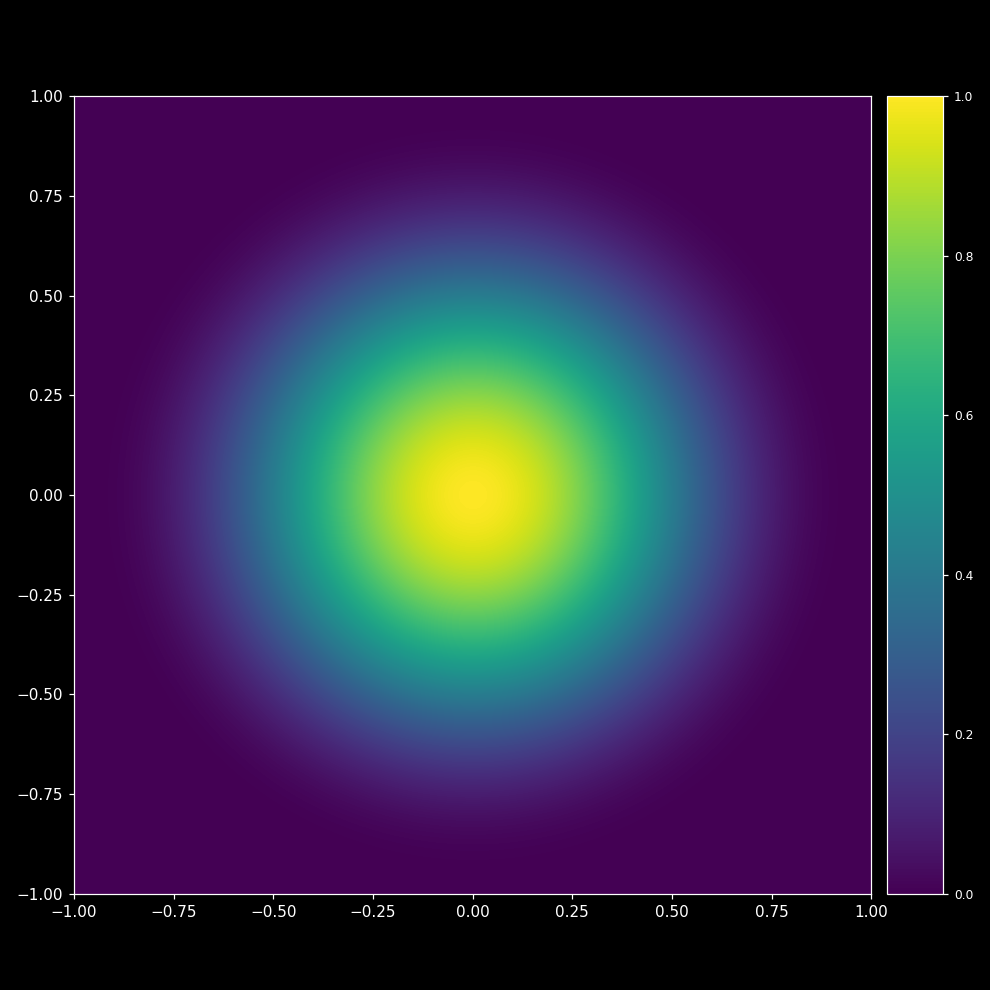

In [39]:
fig, axis = plt.subplots(1, 1, figsize=(9,9), sharex = True, sharey = False, squeeze = False)

# pc = axis[0,0].pcolormesh(xx, yy, zzf.reshape(xx.shape), interpolation = 'linear')
pc = axis[0,0].imshow(window.reshape(xx.shape), interpolation = 'bicubic', extent = [-1,1,-1,1])
axis[0,0].axis('equal')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")

predCbar = fig.colorbar(pc, cax=cax1,orientation='vertical')
predCbar.ax.tick_params(labelsize=8) 

fig.tight_layout()




In [40]:
from cutlass import * 

In [41]:
conv = model.convs[0]
debugPrint(coordinateMapping)

coordinateMapping [str] = preserving


In [42]:

positions = torch.hstack((torch.vstack((xxf,yyf)).mT, torch.zeros(xxf.shape[0],1, device = xxf.device, dtype = xxf.dtype)))
if coordinateMapping == 'polar':
    spherical = mapToSpherical(positions)
    mapped = torch.vstack((spherical[:,0] * 2. - 1.,spherical[:,1] / np.pi)).mT
if coordinateMapping == 'cartesian':
    mapped = positions
if coordinateMapping == 'preserving':
    cubePositions = mapToSpherePreserving(positions)
    mapped = torch.vstack((cubePositions[:,0],cubePositions[:,1] / np.pi)).mT

In [43]:
# debugPrint(mapped)

In [44]:
debugPrint(xxf.shape)
debugPrint(mapped.shape)
debugPrint(u.shape)

xxf.shape [Size] = torch.Size([65025])
mapped.shape [Size] = torch.Size([65025, 2])
u.shape [tuple] = (398,)


In [45]:

u = evalBasisFunction(hyperParameterDict['n'], mapped[:,0], which=hyperParameterDict['rbf_x'], periodic = conv.periodic[0]).T

v = evalBasisFunction(hyperParameterDict['m'], mapped[:,1], which=hyperParameterDict['rbf_y'], periodic = conv.periodic[1]).T
#, torch.ones_like(xxf).unsqueeze(dim=1).to(conv.weight.device)
res = torch.einsum('nu, nv, uvio -> nio',u.to(conv.weight.device),v.to(conv.weight.device),conv.weight).to(u.device).detach().cpu().numpy()
debugPrint(res.shape)
minVal = np.min(res)
maxVal = np.max(res)

minVal = min(minVal, - maxVal)
maxVal = - minVal

res.shape [tuple] = (65025, 6, 32)


In [46]:
layers = len(model.convs)
debugPrint(layers)

layers [int] = 5


In [47]:
inputs = 0
outputs = 0
for layer in range(layers):
    fins = model.convs[layer].weight.shape[2]
    fouts = model.convs[layer].weight.shape[3]
    inputs = max(inputs, fins)
    outputs = max(outputs, fouts)

In [48]:
debugPrint(inputs)
debugPrint(outputs)

inputs [int] = 96
outputs [int] = 64


In [49]:

s = 2
fig, axis = plt.subplots(layers, 1, figsize=(s * inputs, s * layers * outputs), sharex = True, sharey = False, squeeze = False)

# pc = axis[0,0].pcolormesh(xx, yy, zzf.reshape(xx.shape), interpolation = 'linear')

for layer in tqdm(range(layers)):
    conv = model.convs[layer]
    u = evalBasisFunction(hyperParameterDict['n'], mapped[:,0], which=hyperParameterDict['rbf_x'], periodic = conv.periodic[0]).T

    v = evalBasisFunction(hyperParameterDict['m'], mapped[:,1], which=hyperParameterDict['rbf_y'], periodic = conv.periodic[1]).T
    #, torch.ones_like(xxf).unsqueeze(dim=1).to(conv.weight.device)
    res = torch.einsum('nu, nv, uvio, n -> nio',u.to(conv.weight.device),v.to(conv.weight.device),conv.weight, window.to(conv.weight.device)).to(u.device).detach().cpu().numpy()
#     debugPrint(res.shape)
    minVal = np.min(res)
    maxVal = np.max(res)

    minVal = min(minVal, - maxVal)
    maxVal = - minVal

    for fin in range(res.shape[1]):
        for fout in range(res.shape[2]):
#             if coordinateMapping == 'polar' or coordinateMapping == 'preserving':
            res[:,fin,fout][xxf**2 + yyf**2 > 1] = np.nan
#             pc = axis[layer,0].imshow((window * res[:,fin,fout]).reshape(xx.shape), interpolation = 'bicubic', extent = [fin,fin +1,fout,fout +1],interpolation_stage = 'rgba', norm=mpl.colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin= minVal, vmax=maxVal, base=10))
            pc = axis[layer,0].imshow((res[:,fin,fout]).reshape(xx.shape), interpolation = 'bicubic', extent = [fin,fin +1,fout,fout +1],interpolation_stage = 'rgba', vmin = minVal, vmax = maxVal)#norm=mpl.colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin= minVal, vmax=maxVal, base=10))
            
    for fin in range(res.shape[1] - 1):
        for fout in range(res.shape[2] - 1):
            axis[layer,0].axvline(fin + 1, ls = '--',lw=1)
            axis[layer,0].axhline(fout + 1, ls = '--',lw=1)
#     axis[layer,0].set_anchor('W')
#     break

    axis[layer,0].axis('scaled')
    ax1_divider = make_axes_locatable(axis[layer,0])
    cax1 = ax1_divider.append_axes("right", size="3%", pad="5%")

    predCbar = fig.colorbar(pc, cax=cax1,orientation='vertical')
    predCbar.ax.tick_params(labelsize=8) 

for axe in axis:
    for ax in axe:
        ax.set_anchor('W')
    
fig.tight_layout()




<IPython.core.display.Javascript object>

  0%|          | 0/5 [00:00<?, ?it/s]

In [50]:


# # pc = axis[0,0].pcolormesh(xx, yy, zzf.reshape(xx.shape), interpolation = 'linear')

# for layer in tqdm(range(layers)):
#     conv = model.convs[layer]
#     u = evalBasisFunction(hyperParameterDict['n'], mapped[:,0], which=hyperParameterDict['rbf_x'], periodic = conv.periodic[0]).T

#     v = evalBasisFunction(hyperParameterDict['m'], mapped[:,1], which=hyperParameterDict['rbf_y'], periodic = conv.periodic[1]).T
#     #, torch.ones_like(xxf).unsqueeze(dim=1).to(conv.weight.device)
#     res = torch.einsum('nu, nv, uvio -> nio',u.to(conv.weight.device),v.to(conv.weight.device),conv.weight).to(u.device).detach().cpu().numpy()
# #     debugPrint(res.shape)
#     minVal = np.min(res)
#     maxVal = np.max(res)

#     minVal = min(minVal, - maxVal)
#     maxVal = - minVal

#     s = 3
#     fig, axis = plt.subplots(1,1, figsize=(s * res.shape[1] * 1.09, s * res.shape[2]), sharex = False, sharey = False, squeeze = False)
    
#     for fin in range(res.shape[1]):
#         for fout in range(res.shape[2]):
# #             res[:,fin,fout][xxf**2 + yyf**2 > 1] = np.nan
#             pc = axis[0,0].imshow(res[:,fin,fout].reshape(xx.shape), interpolation = 'bicubic', extent = [fin,fin +1,fout,fout +1], vmin = minVal, vmax = maxVal, interpolation_stage = 'rgba')



#     axis[0,0].axis('equal')
#     ax1_divider = make_axes_locatable(axis[0,0])
#     cax1 = ax1_divider.append_axes("right", size="3%", pad="5%")

#     predCbar = fig.colorbar(pc, cax=cax1,orientation='vertical')
#     predCbar.ax.tick_params(labelsize=8) 
#     fig.tight_layout()





In [51]:

# def plot(fig, axis, positions, data, title = 'untitled'):
#     axis.set_title(title)
#     x = positions[:,0].detach().cpu().numpy()
#     y = positions[:,1].detach().cpu().numpy()
#     if len(data.shape) > 1:
#         v = torch.linalg.norm(data, dim =1).detach().cpu().numpy()
#     else:
#         v = data.detach().cpu().numpy()
#     # debugPrint(v)
#     predSC = axis.scatter(x,y,c = v,s=2)
#     axis.axis('equal')
#     axis.set_xlim(-2.5,2.5)
#     axis.set_ylim(-2.5,2.5)
#     axis.axvline(-2., alpha = 0.5, ls = '--')
#     axis.axvline(2, alpha = 0.5, ls = '--')
#     axis.axhline(-2, alpha = 0.5, ls = '--')
#     axis.axhline(2, alpha = 0.5, ls = '--')
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")

#     predCbar = fig.colorbar(predSC, cax=cax1,orientation='horizontal')
#     predCbar.ax.tick_params(labelsize=8) 
    
#     return predSC, predCbar
    

In [80]:
verbose = False

  0%|          | 0/16 [00:00<?, ?it/s]

torch.mean(loss) [Tensor] = 0.09766471225216446


<IPython.core.display.Javascript object>


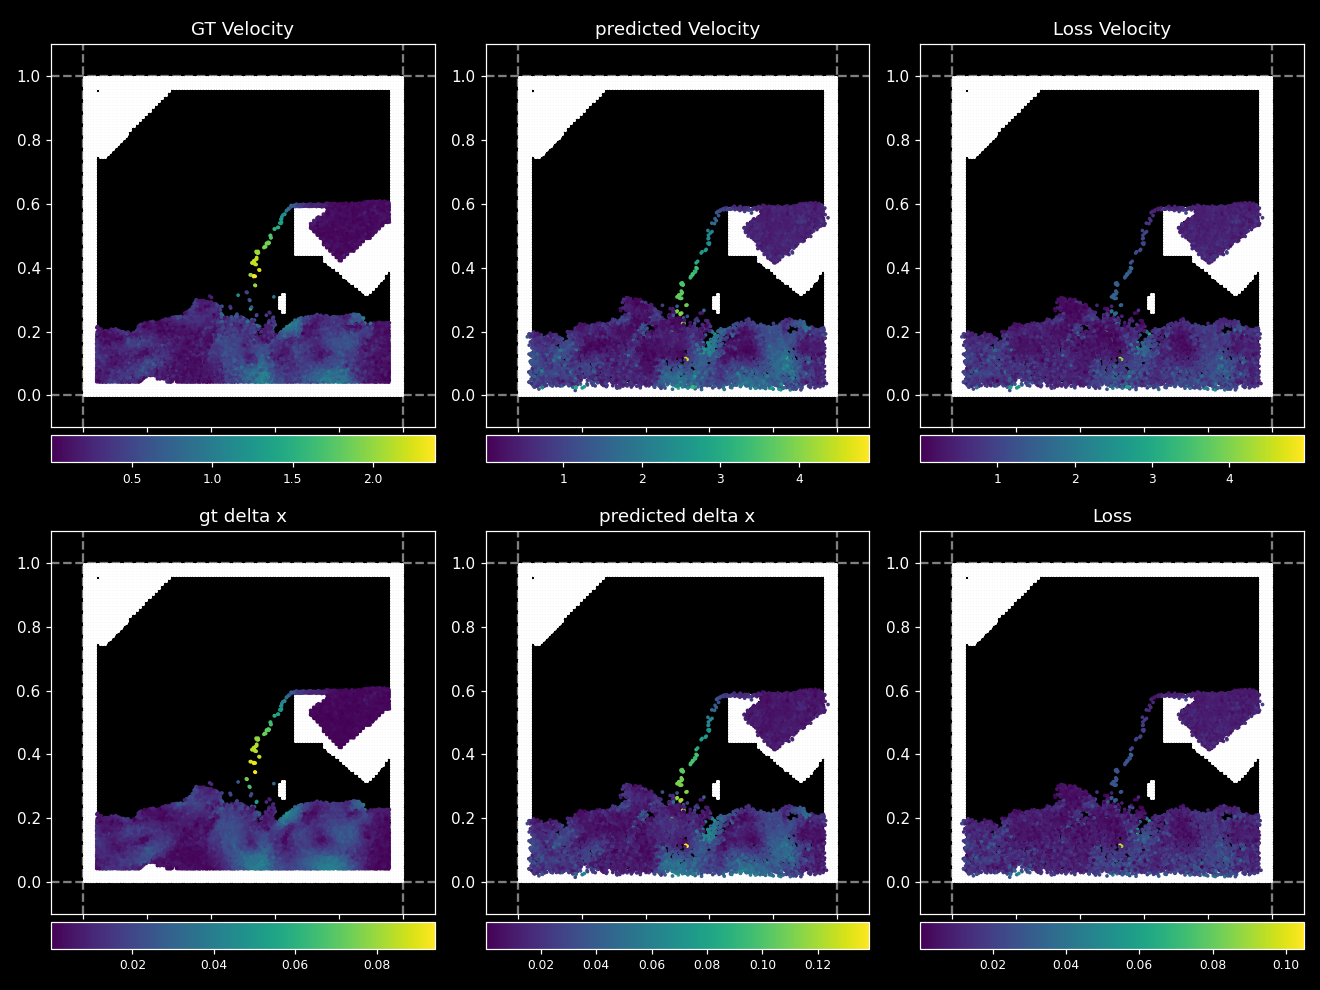

In [89]:
fileName, frameIndex, maxRollout = train_ds[0]
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
# fileName, frameIndex, maxRollout = train_ds[len(train_ds) - 1]
# frameIndex = 750

unroll = 16
attributes, inputData, groundTruths = loadFrame(fileName, frameIndex, 1 + np.arange(unroll), dist)
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

fluidFeatures = fluidFeatures.to(device)

predictedPositions = fluidPositions.to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)

gravity = torch.zeros_like(predictedVelocity)
gravity = inputData['fluidGravity'][:,:2].to(device)
# gravity[:,1] = -9.81

for u in tqdm(range(unroll)):
    loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[u], model, None, None, True)
# loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[1], model, None, None, True)

# loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[2], model, None, None, True)
# loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[3], model, None, None, True)
# loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[4], model, None, None, True)
# loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[5], model, None, None, True)
# loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[6], model, None, None, True)

debugPrint(torch.mean(loss))
fig, axis = plt.subplots(2, 3, figsize=(12,9), sharex = False, sharey = False, squeeze = False)

axis[0,0].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')   
axis[0,1].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')   
axis[0,2].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')   
axis[1,0].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')   
axis[1,1].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')   
axis[1,2].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')    

plot(fig, axis[0,0], positions = fluidPositions, data = groundTruths[u][:,2:4], title = 'GT Velocity')
plot(fig, axis[0,1], positions = predictedPositions, data = predictedVelocity, title = 'predicted Velocity')
plot(fig, axis[0,2], positions = predictedPositions, data = torch.linalg.norm(predictedVelocity - groundTruths[u][:,2:4].to(device), dim = 1), title = 'Loss Velocity')

plot(fig, axis[1,0], positions = fluidPositions, data = groundTruths[u][:,:2] - fluidPositions, title = 'gt delta x')
plot(fig, axis[1,1], positions = predictedPositions, data = predictedPositions - fluidPositions.to(device), title = 'predicted delta x')
plot(fig, axis[1,2], positions = predictedPositions, data = torch.linalg.norm(predictedPositions - groundTruths[u][:,:2].to(device), dim = 1), title = 'Loss')
    
fig.tight_layout()

<IPython.core.display.Javascript object>


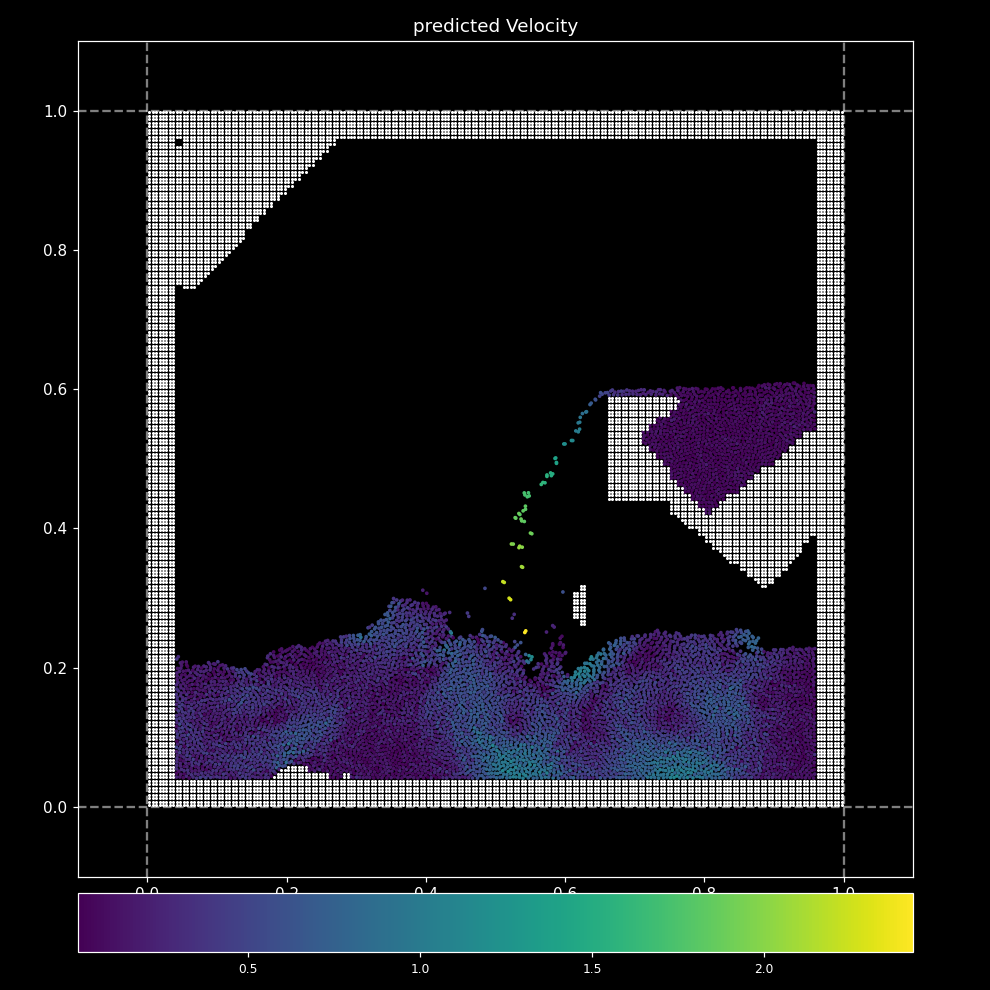

In [88]:
# fileName, frameIndex, maxRollout = train_ds[0]
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
# fileName, frameIndex, maxRollout = train_ds[len(train_ds) - 1]
# frameIndex = 750
attributes, inputData, groundTruths = loadFrame(fileName, frameIndex, 1 + np.arange(1), dist)
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

fluidFeatures = fluidFeatures.to(device)

predictedPositions = fluidPositions.to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)

gravity = torch.zeros_like(predictedVelocity)
gravity = inputData['fluidGravity'][:,:2].to(device)
# gravity[:,1] = -9.81

fig, axis = plt.subplots(1, 1, figsize=(9,9), sharex = False, sharey = False, squeeze = False)
sc, cbar = plot(fig, axis[0,0], positions = predictedPositions, data = predictedVelocity, title = 'predicted Velocity')

axis[0,0].scatter(boundaryPositions[:,0], boundaryPositions[:,1], s = 1, c = 'white')   

fig.tight_layout()


In [85]:

for i in tqdm(range(16)):
    loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[0], model, None, None, True)
    sc.set_offsets(predictedPositions.detach().cpu().numpy())
    sc.set_array(torch.linalg.norm(predictedVelocity,dim=1).detach().cpu().numpy())
    cbar.mappable.set_clim(vmin=np.min(torch.linalg.norm(predictedVelocity,dim=1).detach().cpu().numpy()), vmax=np.max(torch.linalg.norm(predictedVelocity,dim=1).detach().cpu().numpy()))    
    fig.canvas.draw()
    fig.canvas.flush_events()
    
#     fig.savefig('%04d.png' % i, dpi = 300)


  0%|          | 0/16 [00:00<?, ?it/s]

In [1056]:
debugPrint(frameDistance)

frameDistance [int] = 1


In [936]:
from scipy.spatial import cKDTree

In [1037]:
A = predictedPositions.detach().cpu().numpy()
B = groundTruths[0][:,:2].detach().cpu().numpy()
min_dists, min_dist_idx = cKDTree(B).query(A, 1)

In [993]:
# fileName, frameIndex, maxRollout = train_ds[0]
fileName, frameIndex, maxRollout = train_ds[320]
# fileName, frameIndex, maxRollout = train_ds[len(train_ds) - 1]
# frameIndex = 750
n = 64
attributes, inputData, groundTruths = loadFrame(fileName, frameIndex, 1 + np.arange(64), dist)
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

fluidFeatures = fluidFeatures.to(device)

predictedPositions = fluidPositions.to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)

gravity = torch.zeros_like(predictedVelocity)
# gravity[:,1] = -9.81

# fig, axis = plt.subplots(1, 1, figsize=(9,9), sharex = False, sharey = False, squeeze = False)
# sc, cbar = plot(fig, axis[0,0], positions = predictedPositions, data = predictedVelocity, title = 'predicted Velocity')

# fig.tight_layout()

for i in range(n):
    loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[i], model, None, None, True)
    A = predictedPositions.detach().cpu().numpy()
    B = groundTruths[0][:,:2].detach().cpu().numpy()
    min_dists, min_dist_idx = cKDTree(B).query(A, 1)
#     debugPrint(np.mean(min_dists))
#     sc.set_offsets(predictedPositions.detach().cpu().numpy())
#     sc.set_array(torch.linalg.norm(predictedVelocity,dim=1).detach().cpu().numpy())
#     cbar.mappable.set_clim(vmin=np.min(torch.linalg.norm(predictedVelocity,dim=1).detach().cpu().numpy()), vmax=np.max(torch.linalg.norm(predictedVelocity,dim=1).detach().cpu().numpy()))    
#     fig.canvas.draw()
#     fig.canvas.flush_events()


In [944]:

simulationFiles = [basePath + '/' + f for f in os.listdir(basePath) if f.endswith('.hdf5')]
# cutoff = dataDict[subfolders[0]]['hyperParameters']['cutoff']
frameCount = len(train_ds)
# epochs = dataDict['hyperParameters']['epochs']
try:
    inFile = h5py.File(simulationFiles[0], 'r')
    frameCount = int(len(inFile['simulationExport'].keys()) -1) # adjust for bptcls
    inFile.close()
#     debugPrint(frameCount)
#     if cutoff < 0:
#         cutoff = frameCount - 100
except Exception:
    print('data not available defaulting to 1800')
    
debugPrint(frameCount)

frameCount [int] = 1999


In [1057]:
nf = 16
nu = 16
dataMatrix = np.ones((frameCount//nf, frameCount//1)) * np.nan
# np.fill_diagonal(dataMatrix, 1)

In [1060]:

n = 64
    
for i in tqdm(range(0, frameCount - nf, nf)):
    dataMatrix[i//16, i//16] = 0
    steps = n * nu if i + n * nu * dist < frameCount else (frameCount - i) // (dist* nu)
#     debugPrint(steps)
    
    attributes, inputData, groundTruths = loadFrame(fileName, i, 1 + np.arange(steps), dist)
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

    fluidFeatures = fluidFeatures.to(device)

    predictedPositions = fluidPositions.to(device)
    predictedVelocity = inputData['fluidVelocity'].to(device)

    gravity = torch.zeros_like(predictedVelocity)
    # gravity[:,1] = -9.81

    # fig, axis = plt.subplots(1, 1, figsize=(9,9), sharex = False, sharey = False, squeeze = False)
    # sc, cbar = plot(fig, axis[0,0], positions = predictedPositions, data = predictedVelocity, title = 'predicted Velocity')

    # fig.tight_layout()

    for ii in tqdm(range(steps), leave=False):
#         dataMatrix[i//16, i//16 + ii] = ii
        loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[ii], model, None, None, True)
        A = predictedPositions.detach().cpu().numpy()
        B = groundTruths[0][:,:2].detach().cpu().numpy()
        min_dists, min_dist_idx = cKDTree(B).query(A, 1)
#         debugPrint(np.mean(min_dists))
        dataMatrix[i//16, i//16 + ii] = np.mean(min_dists)
    
    
#     break

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


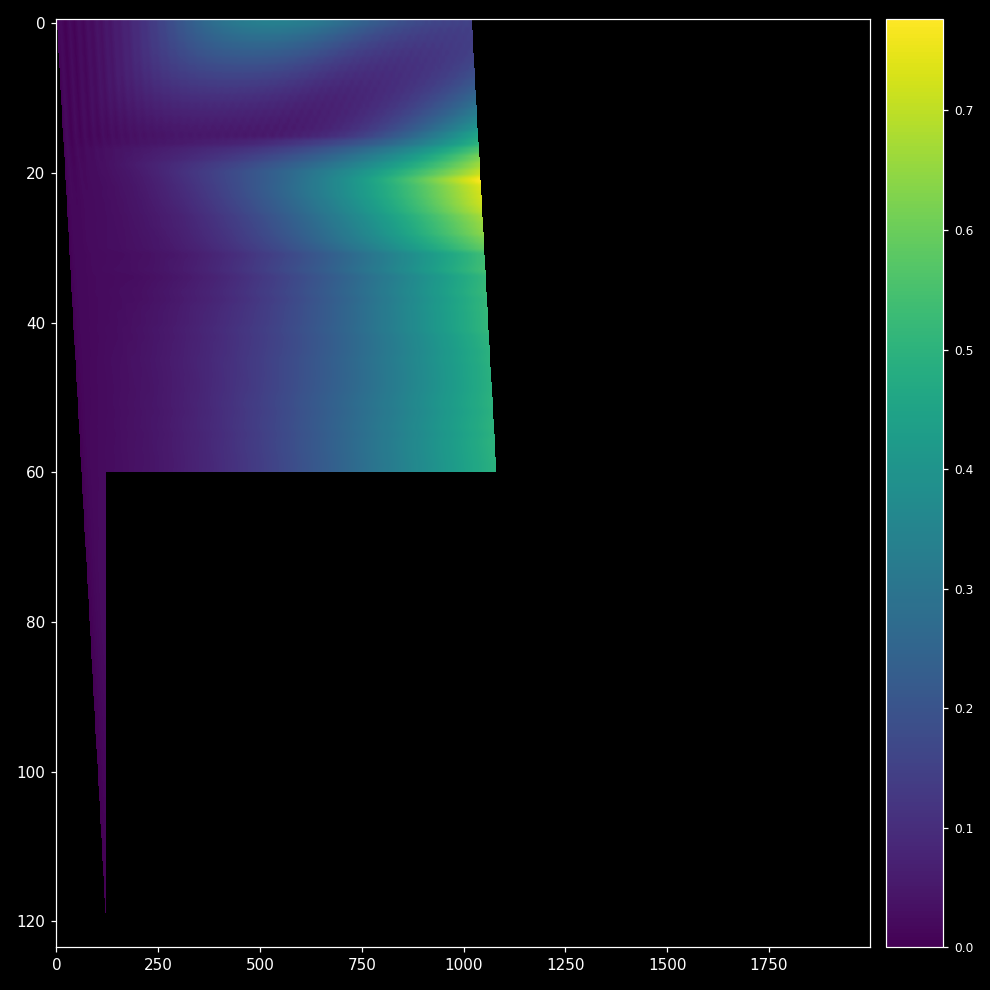

In [1061]:

fig, axis = plt.subplots(1, 1, figsize=(9,9), sharex = False, sharey = False, squeeze = False)

im = axis[0,0].imshow(dataMatrix)
axis[0,0].axis('auto')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")

predCbar = fig.colorbar(im, cax=cax1,orientation='vertical')
predCbar.ax.tick_params(labelsize=8) 

fig.tight_layout()
# sc, cbar = plot(fig, axis[0,0], positions = predictedPositions, data = predictedVelocity, title = 'predicted Velocity')
